<h1>Optimizer-Based QSP Phase Angle Determination: Angler, Expander, and Fitter</h1><br>
<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.


<h2><u>1. Introduction</u></h2>

The `Angler_opt`, `Expander`, and `Fitter` classes handle all of the classical preprocessing that is needed to implement a  function $f(x)$ using an optimizer-determined QSP sequence.  More specifically, these methods calculate a degree-$d$ polynomial approximation $\pi_d(x)$  to $f(x)$, and use this expansion to generate angles $\vec{\phi} = \{\phi^i\}$ that implement $\pi_d(x)$ in a QSP sequence.


<br>
Each of these modules has a distinct role:

1. <b>Fitter:</b> The `Fitter` class generates a degree-$d$ polynomial approximation $\pi_d(x)$ to  $f(x)$ using the Remez multiple exchange method.  The output is a set of coefficients that correspond to a fixed-parity expansion for $\pi_d(x)$ in a Chebyshev basis.  This object may be passed directly to `Angler_opt` for phase angle determination. 
2. <b>Expander:</b> Some functions have convenient analytical expansions for $\pi_d(x)$, which are  generically associated with  rigorously defined error thresholds $\epsilon_0$.  The `Expander` class provides a library of these expansions (described in a separate notebook) which may be invoked by specifying $\epsilon_0$ as a parameter. This object may be passed directly to `Angler_opt` for phase angle determination in lieu of using `Fitter.'
3. <b>Angler:</b> The `Angler_opt` class takes output from `Fitter` or `Expander`  and generates a set of QSP phase angles $\vec{\phi} = \{\phi_i\}$ using a user-specified method. This class can also accept a user-specified set of Chebyshev expansion coefficients, which are passed directly or a `ChebyshevPoly` object. The `Angler_opt` can interconvert between phase angle conventions (W, Z, etc.) and may be passed to SimQSP or PyLIQTR for operator-level simulation or quantum circuit generation, respectively.  <i>[currently implemented phase angle methods: gradient optimizer; in process: Haah, GSLW, infinite QSP, ...]</i>


The workflow between these components can be summarized in a straightforward flowchart:


<div>
<img src="attachment:fig-aef_workflow-2.png" width="600"/>
</div>



We also provide a library `FuncLib` that contains functions relevant to several QSP algorithms, <i>[as well as a module `Blocker` that generates block encodings of varying optimality (dilations for non-Hermitian operators, sparse encodings, full LCU, etc.) - also a to-do.  This component will be described separately.]</i>

We will introduce the phase angle workflow using the function $f(x) = \exp[-\beta x]$ as an example - an exponential that appears in methods for imaginary time evolution and Gibbs state preparation.  This function also has an analytically-defined form that is provided by `Expander`, though it requires separate QSP circuits to implement even- and odd-parity components.  Here, we use `Fitter` to generate a strictly even-parity expansion to $f(x)$ that is more efficient for practical applications.

In [1]:

###
### General imports
###

import numpy                as np
import numpy.linalg         as nla
import scipy.linalg         as sla
import scipy.special        as sfn

import matplotlib.pyplot    as plt
import matplotlib_inline    as mpli
import sys                  as sys

from IPython.display        import display, clear_output

from numpy                  import int8 as int8

###
### Angle generation imports
###

from    pyLIQTR.phase_factors.optimization.fitter                import  Fitter
from    pyLIQTR.phase_factors.optimization.expander              import  Expander
from    pyLIQTR.phase_factors.optimization.angler_optimization   import  Angler_opt
from    pyLIQTR.clam.simqsp                                      import  SimQSP
import  pyLIQTR.clam.operators                                   as      qops
import  pyLIQTR.utils.plot_helpers                               as      ph

###
### Arbitrary precision arithmetic 
###

import mpmath                            as mpm
mpm.mp.prec = 512

###
### Ploting and text output settings
###

mpli.backend_inline.set_matplotlib_formats('svg')
plt.rcParams['text.usetex'] = False
np.set_printoptions(precision=2)
sys.set_int_max_str_digits(100000)


<h2><u>2. Demonstration: Fitter</u></h2>

To demonstrate the our angle generation routines, we use  `Fitter`  to approximate $f(x) = \exp[-\beta \cdot x]$ on the real domain $D = [1/\kappa, 1]$, where $\kappa > 0$ is a constant.  The resulting encoding is sufficient for QSP-based  imaginary time evolution / ground state determination, thermal state preparation, and Gibbs state estimation.

We begin by defining the parameters for the target function, including the desired degree `deg` of polynomial approximation, the parity `parity` of the approximation (`0` = even, `1` = odd, `2` = otherwise), and a lower bound $\kappa^{-1}$ for the approximation domain: 

In [2]:

deg   = 30;       parity   = 0         
kappa = 10;       beta     = 1.0

exp_ite  =  lambda x : mpm.exp(-beta*np.abs(x))


We now invoke an instance of `Fitter`, passing the function `exp_ite`, its parity, and the bound $1/\kappa$ for the target domain (if we specify $\kappa$ without an upper bound the domain is assumed to be $[\kappa^{-1},1]$).  `Fitter` simplifies the Remez procedure by automatically generating a grid of Chebyshev roots on the domain as starting guess.  While this set can be manually specified using the `pts_init=` argument, the default will be optimal in most cases (since it minimizes boundary oscillations).  Thus:

In [3]:

Fit  = Fitter(exp_ite, deg, parity, kappa=kappa)


Our next step is to call the `Fitter.remez()` method, which calculates the best degree $d$ polynomial approximation $\pi_d(x)$ to $f(x)$ and returns its coefficients in a Chebyshev  basis:

In [4]:

Fit.remez();


################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   0.000104456037567403
REMEZ		 Iter:  1 	  Linf_Err:   3.7226265276163374e-05
REMEZ		 Iter:  2 	  Linf_Err:   2.0894939509913772e-05
REMEZ		 Iter:  3 	  Linf_Err:   8.934736671551285e-06
REMEZ		 Iter:  4 	  Linf_Err:   7.277707280808336e-06
REMEZ		 Iter:  5 	  Linf_Err:   7.144180627840012e-06

REMEZ:		FITTING COMPLETE!



Since `Fitter` is derived from our `ChebyshevPoly` class, we may access the resulting coefficient set, objective function, and relative error in a straightforward manner:


In [5]:
print("\n")
print("Chebyshev Coefficients:\n\n", Fit.coeffs.T, "\n")
print("Linf Error:\t", Fit.fit_err_linf, "\n")
print("Relative Error:\t", Fit.fit_err_rel, "\n")
print("Degree:\t", Fit.deg, "\n")



Chebyshev Coefficients:

 [[ 5.55e-01 -2.41e-01  7.58e-02 -3.41e-02  1.89e-02 -1.17e-02  7.87e-03
  -5.54e-03  4.04e-03 -3.02e-03  2.29e-03 -1.77e-03  1.37e-03 -1.07e-03
   8.39e-04 -6.59e-04  5.17e-04 -4.05e-04  3.16e-04 -2.45e-04  1.89e-04
  -1.44e-04  1.09e-04 -8.12e-05  5.96e-05 -4.29e-05  3.01e-05 -2.04e-05
   1.33e-05 -1.23e-05]] 

Linf Error:	 7.144180627840012e-06 

Relative Error:	 8.51936920547356e-05 

Degree:	 30 



We may also evaluate the approximating polynomial $\pi_d(x)$ at some point $x \in [-1,1]$:

In [6]:
Fit.eval(0.2) 

array([0.82])

Fitter is also contains a method to evaluate  both $\pi_d(x)$ and $f(x)$  on a discrete set of points and returns the fitting residual $r(x) = \pi_d(x) - f(x)$.

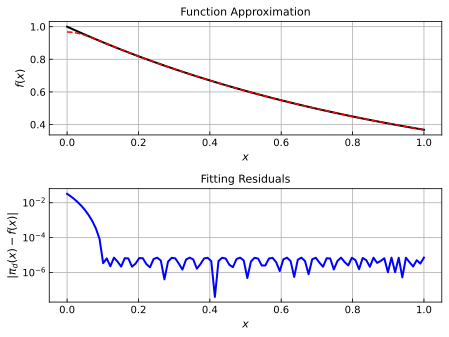

In [7]:

npts = 100;      xvec = np.linspace(0.0,1.0,npts)

BAPx, fx, err = Fit.eval_approx(xvec)

ph.ig_plot_fit(xvec,BAPx,fx,err)


We have plotted the function $f(x)$ as a solid black line, the polynomial $\pi_d(x)$ as a dashed red line, and the residues $r(x) \pi_d(x) - f(x)$ as a blue line.

Finally, we can assess the convergence of the $L^\infty$ norm with respect to the number of Remez iterations.  This is helpful when debugging approximations for more complicated functions:

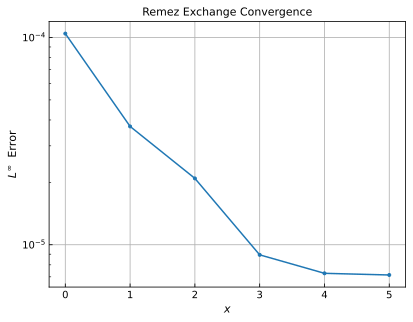

In [8]:

ph.ig_plot_convergence(Fit.conv_err_linf)


The optimized set of fitting points are retained, in case they are to be used later:

In [9]:
Fit.get_pts()

array([0.1 , 0.11, 0.13, 0.17, 0.21, 0.25, 0.3 , 0.34, 0.39, 0.44, 0.48,
       0.53, 0.57, 0.61, 0.66, 0.69, 0.73, 0.77, 0.8 , 0.83, 0.86, 0.89,
       0.91, 0.93, 0.95, 0.96, 0.98, 0.99, 0.99, 1.  , 1.  ])

There are additional options and methods in the `Fitter` class - these are detailed in its module-specific  documentation.

<h2><u>3. Demonstration: Angler_opt</u></h2>

The routines in `Fitter` have provided a degree $d$ Chebyshev polynomial approximation $\pi_d(x)$ to some function $f(x)$.   Using this result, the `Angler_opt` module can generate  phase angles $\vec{\phi} = \{\phi_i\}$ for a QSP sequence $\mathcal{O}_{\vec{\phi}}$ that applies $\pi_d$ some block-encoded operator $\hat{A}$:


\begin{equation}
\begin{pmatrix} \hat{A} & \cdot \\ \cdot & \cdot \end{pmatrix} \mapsto \begin{pmatrix} \pi_d(\hat{A}) & \cdot \\ \cdot & \cdot \end{pmatrix} \approx \begin{pmatrix} f(\hat{A}) & \cdot \\ \cdot & \cdot \end{pmatrix}.
\end{equation}

While the `Angler_opt` accepts a `Fitter` instance as input, we could also generate an analytically-defined set of coefficients using an `Expander` object (or supply them directly as a `numpy` array).  For now, we will use our `Fitter`-based approximation to $f(x) = \exp[-\beta x]$ from preceding demo.

To do so, we pass `Fitter` as a keyword argument to `Angler_opt` (though, by the above, `cheb_poly=` could be either a `Fitter` or an `Expander`).  We also change the convergence criteria for the L-BFGS optimizer (`bfgs_conv`) and set the maximum number of iterations (`max_iter`) for the phase angle generation routines:


In [10]:

Ang = Angler_opt( cheb_poly=Fit, bfgs_conv=1e-14, max_iter=400 )

phi_ite,obj_ite = Ang.gradient_optimization();


################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination             #
################################################################################ 


Iteration		Max. Obj.

1 			1.011314e-02
2 			5.990105e-03
3 			2.340725e-03
4 			1.014623e-03
5 			3.666348e-04
6 			1.234390e-04
7 			3.681188e-05
8 			1.000984e-05
9 			4.593890e-06
10 			2.830066e-06
11 			1.195354e-06
12 			4.220296e-07
13 			1.922553e-07
14 			9.750060e-08
15 			3.258576e-08
16 			1.801183e-08
17 			5.219813e-09
18 			1.430218e-09
19 			4.180778e-10
20 			5.431333e-11
21 			9.051111e-12
22 			1.245829e-12
23 			1.368095e-13
24 			2.023514e-14
25 			9.587815e-16
26 			2.568102e-16
27 			2.530378e-17
28 			7.335067e-19
29 			1.067437e-19
30 			1.617563e-20
31 			8.222686e-22
32 			1.009064e-22
33 			7.273104e-24
34 			3.794878e-25
35 			3.805776e-26
36 			2.660242e-27
37 			1.090169e-28
38 			3.549874e-30

GRADOPT-LBFGS: Opt

The optimizer quickly converges to a set of phase angles.  Additional options and use cases for `Angler_opt` may be found in its stand-alone documentation.

<h2><u>4. Demonstration: SimQSP</u></h2>

We may now perform an operator-level (e.g. gate-free) simulation to test the QSP sequence generated by our phase angles.  This process is automated by the `SimQSP` class, which can be constructed by supplying a defined set of phase angles and their parity (using `phases=` and `parity=` arguments) or directly from an `Angler_opt` instance.  We demonstrate by doing the latter:

In [11]:

Sim_q = SimQSP(angler=Ang)


 `SimQSP` provides a method `eval_sequence(...)` that evaluates the sequence for scalar QSP.  This is invoked by specifying a set of points that will be taken as an argument (we again use `xvec`):

In [12]:

F_qsp  = Sim_q.eval_sequence(xvec)


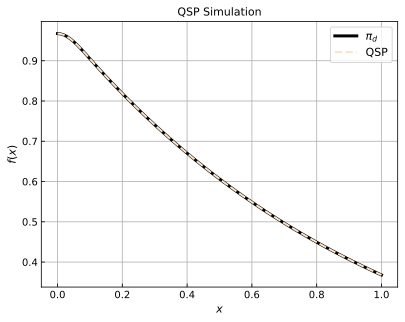

In [13]:

ph.ig_plot_scalar_qsp(xvec,BAPx,F_qsp)


<h2><u>5. Advanced Demonstration: Random Symmetric Matrix</u></h2>

We can also test this workflow using a less trivial instance.  Let's approximate $f(M) = \exp[-\beta M]$ when  $M$ corresponds some random symmetric operator.  We can create a representative $M$  using the QR decomposition of a random matrix $M_\text{rand} \in GL_n(\mathbb{R})$:

In [14]:

D_m = 4

M_rand = np.random.rand(D_m,D_m)

Q,R    = nla.qr(M_rand)
M      = (Q + Q.T) / 2.0
M

array([[-0.39,  0.1 ,  0.01, -0.69],
       [ 0.1 , -0.9 ,  0.11,  0.03],
       [ 0.01,  0.11, -0.73, -0.13],
       [-0.69,  0.03, -0.13,  0.65]])

As a general rule, we must ensure that $\vert\vert M \vert\vert_2 \leq 1$, as required for a block encoding.  This can be accomplished through a min-max rescaling:

In [15]:

evals,evecs = nla.eig(M)

print("Eigenvalues: ", evals)

e_min = np.min(evals)
e_max = np.max(evals)

ID_n = np.eye(4)

M_rs = (M - e_min*ID_n) / (e_max - e_min)        # min/max rescaling

tau  = beta*(e_max-e_min)/2.0                    # rescaled parameter for encoding \exp [-\tau H]


Eigenvalues:  [ 1.   -1.   -0.68 -0.68]


In [16]:
M_rs

array([[ 0.3 ,  0.05,  0.  , -0.34],
       [ 0.05,  0.05,  0.05,  0.01],
       [ 0.  ,  0.05,  0.14, -0.07],
       [-0.34,  0.01, -0.07,  0.82]])

The use of `Fitter` and `Angler_opt` parallels the scalar case above.  However, we must now increase the fitting precision (by raising the target degree $d$) and enlarge the approximation domain based on the condition number of $M$ (by changing $\kappa$):

<i><b>NOTE:</b> This step can have a runtime between five and ten minutes with the specified thresholds and degree (assuming single core execution).</b></i>

In [17]:

deg   = 120;       parity   = 0
kappa = 30;       

exp_ite  =  lambda x : mpm.exp(-tau*np.abs(x))

# Fitting
Fit  = Fitter(exp_ite, deg, parity, kappa=kappa);
Fit.remez();

Fit.root_solver = 'ridder'  # switch to a slightly faster root solver
                            # though convergence can be erratic.
Fit.r_eps_tot   = 1.0e-6

    
# Angle generation
Ang = Angler_opt(cheb_poly=Fit, bfgs_conv=1e-8, max_iter=400 );   
Ang.gradient_optimization();


################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   1.0371462920879783e-05
REMEZ		 Iter:  1 	  Linf_Err:   2.8283333567464088e-06
REMEZ		 Iter:  2 	  Linf_Err:   1.4268590356486477e-06
REMEZ		 Iter:  3 	  Linf_Err:   1.0639227970214675e-06
REMEZ		 Iter:  4 	  Linf_Err:   4.1370150652484005e-07

REMEZ:		FITTING COMPLETE!

################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination             #
################################################################################ 


Iteration		Max. Obj.

1 			1.182663e-02
2 			7.538882e-03
3 			3.422059e-03
4 			1.754424e-03
5 			8.237118e-04
6 			3.954820e-04
7 			1.906298e-04
8 			9.461384e-05
9 			4.854569e-05
10 			2.689173e-05
11 


Since we are now working with a matrix (operator), we will require a block encoding.  A minimal block encoding can be quickly generated by invoking the `get_qsp_operators(M)` method from `SimQSP`.  This also produces components for the QSP phase sequence, including as the encoding unitary $U_M$, the identity $I_{M}$ and reflector $Z_\Pi$ on the qubitized space, and the QSP rotation operator $R_M$.


In [18]:

# QSP simulation methods
Sim_q  = SimQSP(angler=Ang);
Sim_q.get_qsp_operators(M_rs)

# Uncomment to display any of the components:
#
# Sim_q.IdM        # Identity operator
# Sim_q.ZPi        # Reflection operator on qubitized space
# Sim_q.Ua         # Block-encoding unitary
# Sim_q.Rot        # QSP rotation operator [qubitized y-rotation]


If enduring access to the phase operators $Z_{\phi_i} = \exp\left[-\imath \phi_i \hat{Z}\right]$ is required, they must be generated using a separate method:

In [19]:

#Sim_q.get_qsp_phase_operators()
#
# Sim_q.phaseops[0]     #  exp[-i phi_0 Z]
# Sim_q.phaseops[1]     #  exp[-i phi_1 Z]
# etc.


The QSP unitary $\mathcal{O}$ can be produced using the `qsp_sequence()` method.  While this operator is returned by the method, by can also be accessed from `<QimQSP>.qsp_seq` after it has been computed.  Note that this method will generate the phase vectors automatically if they have not already been created using `get_phase_operators()`.  Conversely, these are fetched from the `phaseops` array (without recalculation) if they already exist.

In [20]:

Sim_q.qsp_sequence();

#Sim_q.qsp_seq


The default phase angle sequence encodes $f(M)$ as a real function, and the desired block can be accessed by using $\vert + \rangle = (\vert 0 \rangle + \vert 1 \rangle) / \sqrt{2}$ as a signal state.  That is,

\begin{equation}
\pi_d(M) =  \big(\langle + \vert \otimes I_n\big) \,\hat{\mathcal{O}}\, \big(\vert + \rangle \otimes I_n\big)
\end{equation}

which we can extract in a straightforward fashion:

In [21]:

sig_qsp  = np.kron(np.array([[1,1]]),np.eye(D_m)) / np.sqrt(2)

M_qsp = sig_qsp @ Sim_q.qsp_sequence() @ sig_qsp.T

np.real(M_qsp)

array([[ 0.78, -0.04,  0.  ,  0.2 ],
       [-0.04,  0.95, -0.05, -0.02],
       [ 0.  , -0.05,  0.87,  0.04],
       [ 0.2 , -0.02,  0.04,  0.47]])

In [22]:

M_exact = sla.expm(-M_rs)
M_exact


array([[ 0.78, -0.05,  0.  ,  0.2 ],
       [-0.05,  0.95, -0.05, -0.02],
       [ 0.  , -0.05,  0.87,  0.04],
       [ 0.2 , -0.02,  0.04,  0.47]])

This result is - by visual inspection - close to the desired result. We can make this quantitative by directly comparing the relative error between individual elements:

In [23]:
np.abs((M_exact - M_qsp) / M_exact)

array([[0.  , 0.06, 0.26, 0.  ],
       [0.06, 0.01, 0.06, 0.09],
       [0.26, 0.06, 0.  , 0.02],
       [0.  , 0.09, 0.02, 0.  ]])

This precision can be improved by increasing $\kappa$ and the degree of the fitting polynomial in tandem.

<b>Note:</b> <i>A quantum singular value transform can be invoked using the `qsp_sequence()` method.  This requires a rescaling of phase factors (different conventions are used for the quantum eigenvalue / singular value transform and for QSP), with angles as phase operators that are obtained using the `get_qsvt_angles` and `get_qsp_phase_operators` methods, respectively.<i>

<h2><u>6. References</u></h2>

<i>Optimizer-based angle generation procedures are detailed in the following manuscripts:</i>

1. Y. Dong, X. Meng, K. B. Whaley, and L. Lin, "Efficient phase-factor evaluation in quantum signal processing." Phys. Rev. A. <b>103</b>, 042419 (2021). [<a href="https://doi.org/10.1103/PhysRevA.103.042419">Journal</a>] [<a href="
https://doi.org/10.48550/arXiv.2002.11649">arXiv</a>]
2. J. Wang, Y. Dong, and L. Lin, "On the energy landscape of symmetric quantum signal processing." Quantum <b>6</b>, 850 (2022). [<a href="https://doi.org/10.22331/q-2022-11-03-850">Journal</a>] [<a href="https://doi.org/10.48550/arXiv.2110.04993">arXiv</a>]